# Generalization performance of the GNN model to other conditions

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 55.4 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00


In [3]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 643.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=c11d667bd144bbda6e958234929bfc5ec5ea3f18d12e8afef64c452dc6b55d33
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1


In [6]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
from matplotlib.colors import Normalize
import sklearn
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset
from torch_geometric.utils import scatter
from torch_geometric.data import Batch
from torch.utils.data import Dataset

# RDKit
import rdkit
from rdkit import Chem
import mordred
from mordred.Polarizability import APol, BPol
from mordred.TopoPSA import TopoPSA
from rdkit.Chem import rdMolDescriptors
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
print('Mordred version:', mordred.__version__)
tqdm.pandas()

Pytorch version: 2.1.0+cu121
Pytorch Geometric version: 2.5.0
RDKit version: 2023.09.5
Mordred version: 1.2.0


## Load data

In [7]:
df = pd.read_csv('data_cleaned.csv')

since we will analyze the performance of the model when generalizign to other conditions, we will create different train/test splits for every case. Let's then eliminate the original Split column from the dataframe

In [8]:
df = df.drop('Split', axis=1)

## Add SMILES

In [9]:
df_hba = pd.read_csv('HBA_smiles.csv')
df_hbd = pd.read_csv('HBD_smiles.csv')

In [10]:
df['HBA_SMILES'] = df['HBA name'].map(df_hba.set_index('Short')['SMILES'])
df['HBD_SMILES'] = df['HBD name'].map(df_hbd.set_index('Short')['SMILES'])

## Create molecules

In [11]:
df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)

## Compute molecular descriptors

### Atomic polarizability

In [12]:
ap_fun = APol()
df['ap_hba'] = df['mol_hba'].apply(ap_fun)
df['ap_hbd'] = df['mol_hbd'].apply(ap_fun)

### Bond polarizability

In [13]:
bp_fun = BPol()
df['bp_hba'] = df['mol_hba'].apply(bp_fun)
df['bp_hbd'] = df['mol_hbd'].apply(bp_fun)

### Topological polar surface area

In [14]:
topopsa_fun = TopoPSA()
df['topopsa_hba'] = df['mol_hba'].apply(topopsa_fun)
df['topopsa_hbd'] = df['mol_hbd'].apply(topopsa_fun)

### Intra-molecular hydrogen-bonding sites

In [15]:
def get_hb_sites(mol):
  return min(rdMolDescriptors.CalcNumHBA(mol), rdMolDescriptors.CalcNumHBD(mol))

df['hb_hba'] = df['mol_hba'].apply(get_hb_sites)
df['hb_hbd'] = df['mol_hbd'].apply(get_hb_sites)

### Inter-molecular hydrogen bonding sites

In [16]:
def get_inter_hb_sites(row):
    mol1 = row['mol_hba']
    mol2 = row['mol_hbd']
    return min(rdMolDescriptors.CalcNumHBA(mol1), rdMolDescriptors.CalcNumHBD(mol2)) + \
           min(rdMolDescriptors.CalcNumHBA(mol2), rdMolDescriptors.CalcNumHBD(mol1))


df['inter_hb'] = df.apply(get_inter_hb_sites, axis=1)

## Utilities for creating graphs

In [17]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

### Atomic features

In [18]:
possible_atom_list = [
    'C',
    'O',
    'N',
    'Cl',
    'Br',
    'P',
    ]
possible_hybridization = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3
    ]
possible_num_bonds = [
    0,
    1,
    2,
    3,
    4
    ]
possible_formal_charge = [
    0,
    1,
    -1
    ]
possible_num_Hs  = [
    0,
    1,
    2,
    3
    ]

def atom_features(atom):
    '''
    Get atom features
    '''
    Symbol       = atom.GetSymbol()
    Type_atom     = one_of_k_encoding(Symbol, possible_atom_list)
    Ring_atom     = [atom.IsInRing()]
    Aromaticity   = [atom.GetIsAromatic()]
    Hybridization = one_of_k_encoding(atom.GetHybridization(), possible_hybridization)
    Bonds_atom    = one_of_k_encoding(len(atom.GetNeighbors()), possible_num_bonds)
    Formal_charge = one_of_k_encoding(atom.GetFormalCharge(), possible_formal_charge)
    num_Hs        = one_of_k_encoding(atom.GetTotalNumHs(), possible_num_Hs)

    results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
      Formal_charge + num_Hs
    return np.array(results).astype(np.float32)

### Bond features

In [19]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def bond_features(bond):
    bt = bond.GetBondType()
    # Features
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)

## Utilities

In [20]:
def n_atom_features():
    atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
    return len(atom_features(atom))

def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

def sys2graph(df, mol_column_1, mol_column_2, target, single_system=False):
    """
    Constructs graph representations of binary molecular systems.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    mol_column_1 (str): Column name for the first component.
    mol_column_2 (str): Column name for the second component.
    target (str): Column name for the target variable.
    single_system (bool, optional): Whether to treat the dataframe as a single system.

    Returns:
    list: A list of graph objects.
    """
    def process_component(comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(c1, c2, y_val):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [atom_features(atom) for atom in atoms_c1]
        node_features_c2 = [atom_features(atom) for atom in atoms_c2]

        edge_attr_c1, edge_index_c1 = process_component(c1)
        edge_attr_c2, edge_index_c2 = process_component(c2)

        # Info to graphs
        graph_c1 = info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(row, mol_column_1, mol_column_2, target):
        graph_c1, graph_c2 = create_graph_indiv(row[mol_column_1], row[mol_column_2], row[target])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            graph.P = row['P_norm']
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    # Main function logic
    graphs_c1, graphs_c2 = zip(*df.apply(create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2, target)))
    return graphs_c1, graphs_c2

## Graph Neural Network

In [21]:
class MPNNconv(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats=32, num_step_message_passing=1):
        super(MPNNconv, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )

        self.num_step_message_passing = num_step_message_passing

        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats*node_out_feats)
        )
        self.gnn_layer = gnn.NNConv(
            node_out_feats,
            node_out_feats,
            edge_network,
            aggr='add'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def reset_parameters(self):
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, system_graph):

        node_feats = system_graph.x
        edge_index = system_graph.edge_index
        edge_feats = system_graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            if torch.cuda.is_available():
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor).cuda(),
                                                   edge_index=edge_index.type(torch.LongTensor).cuda(),
                                                   edge_attr=edge_feats.type(torch.FloatTensor).cuda()))
            else:
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor),
                                                   edge_index=edge_index.type(torch.LongTensor),
                                                   edge_attr=edge_feats.type(torch.FloatTensor)))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)
        return node_feats

class EdgeModel(torch.nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in*2 + e_in + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr, u[batch]], axis=1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, v_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.node_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0), reduce='sum')
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(hidden_dim + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.global_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        node_aggregate = scatter(x, batch, dim=0, reduce='sum')
        edge_aggregate = scatter(edge_attr, batch[edge_index[1]], dim=0, reduce='sum')
        out = torch.cat([u, node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

class GHGNN(nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim, n_extra_inputs):
        super(GHGNN, self).__init__()
        self.graphnet1 = gnn.MetaLayer(EdgeModel(v_in, e_in, u_in, hidden_dim),
                                      NodeModel(v_in, u_in, hidden_dim),
                                      GlobalModel(u_in, hidden_dim))
        self.graphnet2 = gnn.MetaLayer(EdgeModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim),
                                      NodeModel(hidden_dim, hidden_dim, hidden_dim),
                                      GlobalModel(hidden_dim, hidden_dim))

        self.gnorm1 = gnn.GraphNorm(hidden_dim)
        self.gnorm2 = gnn.GraphNorm(hidden_dim)

        self.pool = global_add_pool

        self.global_conv1 = MPNNconv(node_in_feats=hidden_dim*2,
                                     edge_in_feats=1,
                                     node_out_feats=hidden_dim*2)

        # MLP
        self.mlp1 = nn.Linear(hidden_dim*4 + n_extra_inputs, hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim, hidden_dim)
        self.mlp3 = nn.Linear(hidden_dim, 1)

    def generate_sys_graph(self, x, edge_attr, batch_size, n_mols=2):

        src = np.arange(batch_size)
        dst = np.arange(batch_size, n_mols*batch_size)

        self_connection = np.arange(n_mols*batch_size)

        # Biderectional connections (between each molecule in the system)
        # and self-connection
        one_way = np.concatenate((src, dst, self_connection))
        other_way = np.concatenate((dst, src, self_connection))
        edge_index = torch.tensor([list(one_way),
                                   list(other_way)], dtype=torch.long)
        sys_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return sys_graph

    def forward(self, c1, c2):
        # ---- Atomic polarizability
        ap1 = c1.ap.reshape(-1,1)
        ap2 = c2.ap.reshape(-1,1)

        # ---- Bond polarizability
        bp1 = c1.bp.reshape(-1,1)
        bp2 = c2.bp.reshape(-1,1)

        # -- Polarity via topological polar surface area
        topopsa1 = c1.topopsa.reshape(-1,1)
        topopsa2 = c2.topopsa.reshape(-1,1)

        # -- Hydrogen-bond acidity and basicity
        intra_hb1 = c1.inter_hb
        intra_hb2 = c2.inter_hb

        u1 = torch.cat((ap1,bp1,topopsa1), axis=1) # Molecular descriptors molecule 1
        u2 = torch.cat((ap2,bp2,topopsa2), axis=1) # Molecular descriptors molecule 2

        # Molecule 1 GraphNet
        x1, edge_attr1, u1 = self.graphnet1(c1.x, c1.edge_index, c1.edge_attr, u1, c1.batch)
        x1 = self.gnorm1(x1, c1.batch)
        x1, edge_attr1, u1 = self.graphnet2(x1, c1.edge_index, edge_attr1, u1, c1.batch)
        x1 = self.gnorm2(x1, c1.batch)
        xg1 = self.pool(x1, c1.batch)

        # Molecule 2 GraphNet
        x2, edge_attr2, u2 = self.graphnet1(c2.x, c2.edge_index, c2.edge_attr, u2, c2.batch)
        x2 = self.gnorm1(x2, c2.batch)
        x2, edge_attr2, u2 = self.graphnet2(x2, c2.edge_index, edge_attr2, u2, c2.batch)
        x2 = self.gnorm2(x2, c2.batch)
        xg2 = self.pool(x2, c2.batch)

        batch_size = c1.y.shape[0]

        # Intermolecular descriptors
        # -- Hydrogen bonding
        inter_hb  = c1.inter_hb
        # Construct binary system graph
        node_feat = torch.cat((
            torch.cat((xg1, u1), axis=1),
            torch.cat((xg2, u2), axis=1)),axis=0)
        edge_feat = torch.cat((inter_hb.repeat(2),
                               intra_hb1,
                               intra_hb2)).unsqueeze(1)
        binary_sys_graph = self.generate_sys_graph(x=node_feat,
                                                   edge_attr=edge_feat,
                                                   batch_size=batch_size)
        xg = self.global_conv1(binary_sys_graph)


        xg = torch.cat((xg[0:len(xg)//2,:], xg[len(xg)//2:,:]), axis=1)

        T = torch.reshape(c1.Temp,(-1,1))
        P = torch.reshape(c2.P,(-1,1))
        x1 = torch.reshape(c1.mol_x,(-1,1))
        x2 = torch.reshape(c2.mol_x,(-1,1))

        ExtraVar = torch.cat((T,P,x1,x2),1)
        x = torch.cat((xg,ExtraVar),1)
        x = F.sigmoid(self.mlp1(x))
        x = F.sigmoid(self.mlp2(x))
        x = self.mlp3(x)
        return x

class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
class PairDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
    def __len__(self):
        return len(self.datasetA)

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB

def get_dataloader_pairs(df, graphs_c1, graphs_c2, batch_size, shuffle=False, drop_last=False):

    g1s = df[graphs_c1].tolist()
    g2s  = df[graphs_c2].tolist()

    pair_dataset = PairDataset(g1s, g2s)
    data_loader  = torch.utils.data.DataLoader(pair_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=collate)

    return data_loader

In [23]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for batch_c1, batch_c2 in dataloader:
        y =  batch_c1.y
        X1 = batch_c1
        X2 = batch_c2
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X1, X2)
        loss = loss_fn(y_hat, y.reshape(-1,1))
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for batch_c1, batch_c2 in dataloader:
            y =  batch_c1.y
            X1 = batch_c1
            X2 = batch_c2
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Model prediction and loss calculation
            y_hat = model(X1, X2)
            loss = loss_fn(y_hat, y.reshape(-1,1))
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

In [24]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat, color_vals=None):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'MSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)


  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$MAPE = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$MSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['MSE']**0.5))

  fig , ax2 = plt.subplots(figsize=(5,5))
  ax2.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax2.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax2.set_ylim([-7.5,-0.5])
  ax2.set_xlim([-7.5,-0.5])
  ax2.text(-6.8,-2.5, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.plot(np.linspace(-7,-1),np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  if color_vals is not None:
    sc2 = ax2.scatter(y_test, y_test_hat,label='Testing', c=color_vals, cmap='viridis', marker='.')
    norm2 = Normalize(vmin=np.min(color_vals), vmax=np.max(color_vals))
    cbar2 = plt.colorbar(sc2, ax=ax2, norm=norm2)
  else:
    sc2 = ax2.scatter(y_test, y_test_hat, label='Testing', marker='.', color='blue')
  ax2.legend(loc="best")


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.MSELoss(reduction='mean')
epochs = 1000

## Generalization to other temperatures


Here, we will split the data to test generalization on three cases:

1.   Extrapolating to lower temperatures
2.   Extrapolating to upper temperatures
3.   Interpolating among temperatures

Let's safe at this point a copy of the dataframe for constructing each case from it


In [26]:
df_org = df.copy()

### 1. Extrapolating to lower temperatures

In [ ]:
test_size = 0.30

threshold = 293.15
mask_lower_T = df['T (K)'] < threshold
while mask_lower_T.sum()/mask_lower_T.shape[0] < test_size:
  threshold += 1
  mask_lower_T = df['T (K)'] < threshold

print('Test proportion: ', mask_lower_T.sum()/mask_lower_T.shape[0])
print('Threshold T: ', threshold)

Test proportion:  0.39483020780537254
Threshold T:  304.15


In [ ]:
df['Split'] = 'Training'
df.loc[mask_lower_T, 'Split'] = 'Testing'
df['Split'].value_counts()

Training    1194
Testing      779
Name: Split, dtype: int64

In [ ]:
df[['Split', 'T (K)']]

,Split,T (K)
0,Testing,303.15
1,Testing,303.15
2,Testing,303.15
3,Testing,303.15
4,Testing,303.15
...,...,...
1968,Training,328.15
1969,Training,328.15
1970,Training,328.15
1971,Training,328.15


#### Normalizing data

In [ ]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

#### Create graphs

In [ ]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

#### Dataloaders

In [ ]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

#### Train GNN

In [ ]:
model_name = 'GNN_lower_T'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

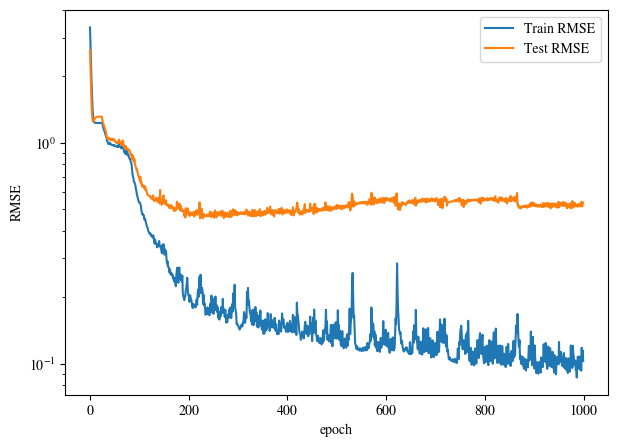

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

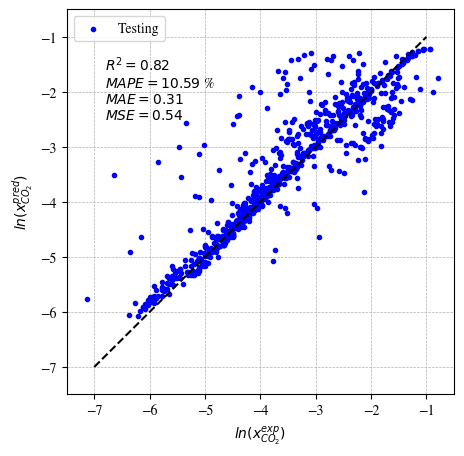

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

Let's now isolate the datapoints in the test set for which we have seen the exact same DES, pressure and composition conditions. This will help us in observign only the performance on exclusively new temperature conditions

In [ ]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have not been seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with pressures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['P (kPa)'].isin(train_df['P (kPa)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_T = test_df_exclusive['T (K)'].values # threshold - test_df_exclusive['T (K)'].values

Original test points:  779
Eliminated test points:  658
Remaining test points:  121


In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

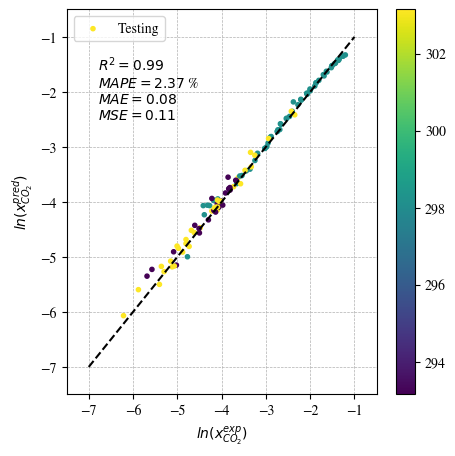

In [ ]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_T)

### 2. Extrapolating to upper temperatures

In [ ]:
df = df_org.copy()

In [ ]:
test_size = 0.3

threshold = 348.15
mask_upper_T = df['T (K)'] > threshold
while mask_upper_T.sum()/mask_upper_T.shape[0] < test_size:
  threshold -= 1
  mask_upper_T = df['T (K)'] > threshold

print('Test proportion: ', mask_upper_T.sum()/mask_upper_T.shape[0])
print('Threshold T: ', threshold)

Test proportion:  0.31474911302584896
Threshold T:  322.15


In [ ]:
df['Split'] = 'Training'
df.loc[mask_upper_T, 'Split'] = 'Testing'
df['Split'].value_counts()

Training    1352
Testing      621
Name: Split, dtype: int64

In [ ]:
df[['Split', 'T (K)']]

,Split,T (K)
0,Training,303.15
1,Training,303.15
2,Training,303.15
3,Training,303.15
4,Training,303.15
...,...,...
1968,Testing,328.15
1969,Testing,328.15
1970,Testing,328.15
1971,Testing,328.15


In [ ]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

In [ ]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

In [ ]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [ ]:
model_name = 'GNN_upper_T'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

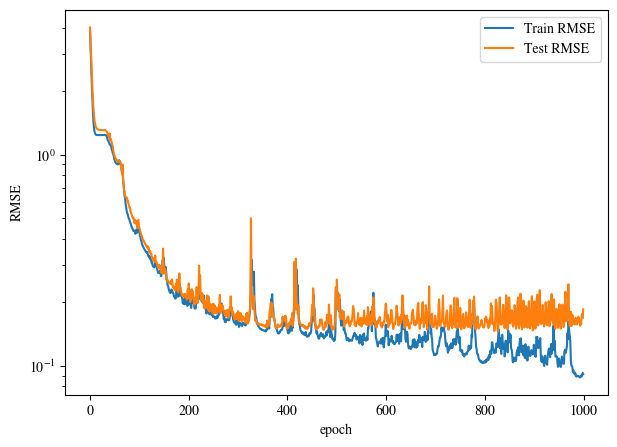

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

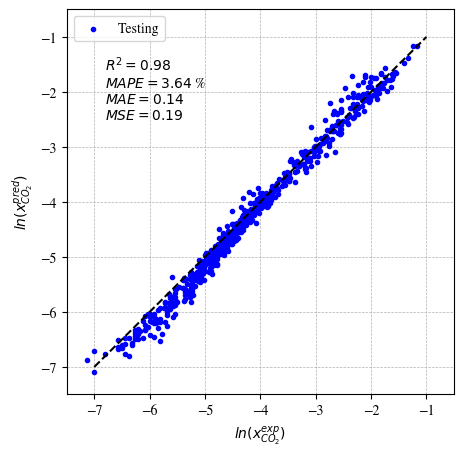

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [ ]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have been not seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with pressures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['P (kPa)'].isin(train_df['P (kPa)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_T = test_df_exclusive['T (K)'].values # test_df_exclusive['T (K)'].values - threshold

Original test points:  621
Eliminated test points:  487
Remaining test points:  134


In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

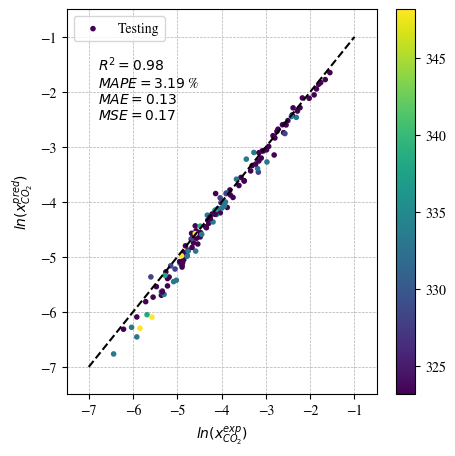

In [ ]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_T)

### 3. Interpolating among temperatures

In [ ]:
df = df_org.copy()

In [ ]:
train_size = 0.70

threshold_1 = 293.15
threshold_2 = 348.15
mask_inter_T = (df['T (K)'] < threshold_1) | (df['T (K)'] > threshold_2)
while mask_inter_T.sum()/mask_inter_T.shape[0] < train_size:
  threshold_1 += 1
  threshold_2 -= 1
  mask_inter_T = (df['T (K)'] < threshold_1) | (df['T (K)'] > threshold_2)

print('Train size: ', mask_inter_T.sum()/mask_inter_T.shape[0])
print('Threshold 1 T: ', threshold_1)
print('Threshold 2 T: ', threshold_2)

Train size:  0.7785098834262545
Threshold 1 T:  314.15
Threshold 2 T:  327.15


In [ ]:
df['Split'] = 'Testing'
df.loc[mask_inter_T, 'Split'] = 'Training'
df['Split'].value_counts()

Training    1536
Testing      437
Name: Split, dtype: int64

In [ ]:
df[['Split', 'T (K)']]

,Split,T (K)
0,Training,303.15
1,Training,303.15
2,Training,303.15
3,Training,303.15
4,Training,303.15
...,...,...
1968,Training,328.15
1969,Training,328.15
1970,Training,328.15
1971,Training,328.15


In [ ]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

In [ ]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

In [ ]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [ ]:
model_name = 'GNN_inter_T'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

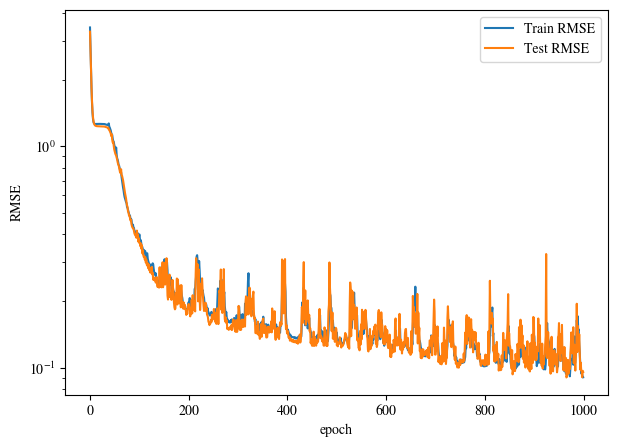

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

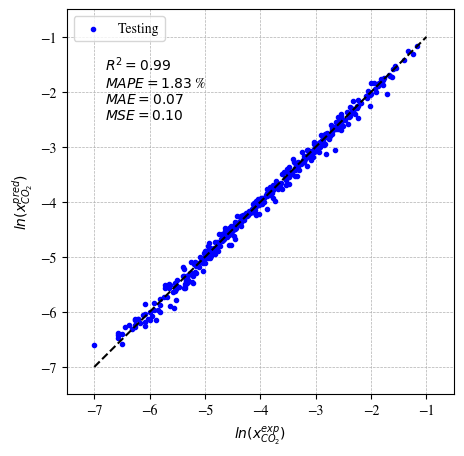

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [ ]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have been not seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with pressures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['P (kPa)'].isin(train_df['P (kPa)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
delta_T = test_df_exclusive['T (K)'].values
y_test_excl = test_df_exclusive['ln(x)-experimental'].values

Original test points:  437
Eliminated test points:  286
Remaining test points:  151


In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

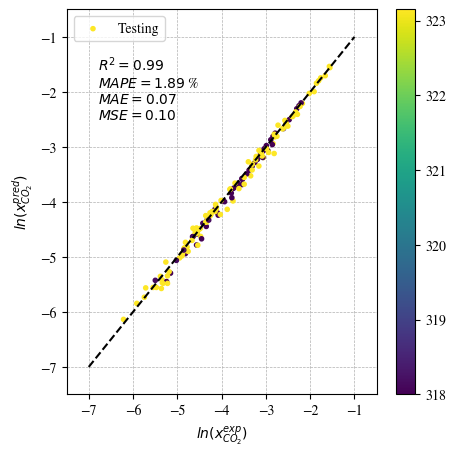

In [ ]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, delta_T)

## Generalization to other pressures

### 1. Extrapolating to lower pressures

In [27]:
df = df_org.copy()

In [28]:
test_size = 0.30

threshold = 26.3
mask_lower_P = df['P (kPa)'] < threshold
while mask_lower_P.sum()/mask_lower_P.shape[0] < test_size:
  threshold += 1
  mask_lower_P = df['P (kPa)'] < threshold

print('Test proportion: ', mask_lower_P.sum()/mask_lower_P.shape[0])
print('Threshold P: ', threshold)

Test proportion:  0.3005575266092245
Threshold P:  320.3


In [29]:
df['Split'] = 'Training'
df.loc[mask_lower_P, 'Split'] = 'Testing'
df['Split'].value_counts()

Training    1380
Testing      593
Name: Split, dtype: int64

In [30]:
df[['Split', 'P (kPa)']]

,Split,P (kPa)
0,Testing,63.7
1,Testing,107.6
2,Testing,192.5
3,Testing,288.3
4,Training,382.9
...,...,...
1968,Testing,112.5
1969,Training,421.4
1970,Training,816.0
1971,Training,1138.5


In [31]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

In [32]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

In [33]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [34]:
model_name = 'GNN_lower_P'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

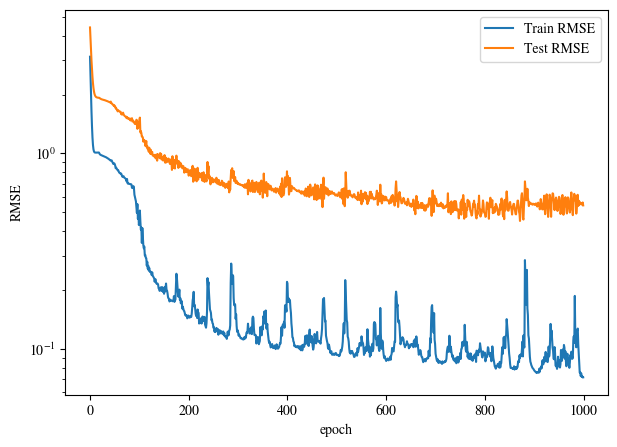

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [35]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

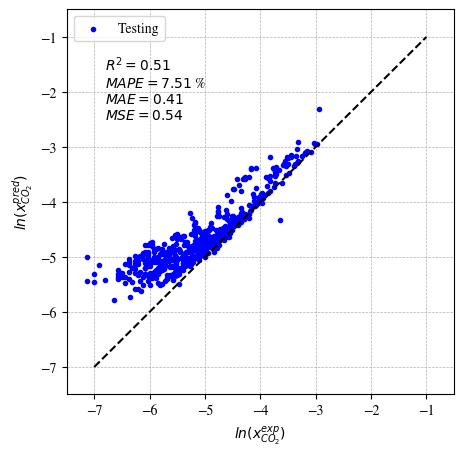

In [36]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [37]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have not been seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with temperatures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['T (K)'].isin(train_df['T (K)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_P = test_df_exclusive['P (kPa)'].values #threshold - test_df_exclusive['P (kPa)'].values

Original test points:  593
Eliminated test points:  0
Remaining test points:  593


In [38]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

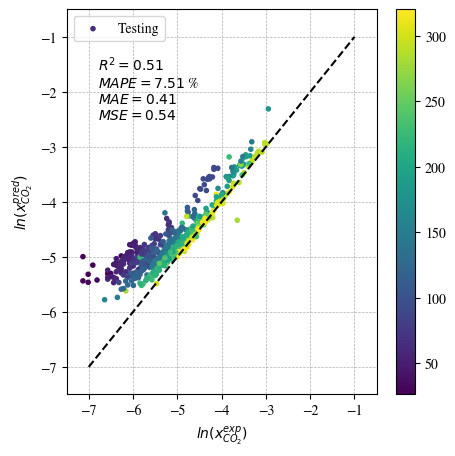

In [39]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_P)

Lets define a threshold value of 250 kPa to determinate the performance of the model at closer values of the training set.

Original test points:  593
Threshold value:  256.08000000000004
Eliminated test points:  485
Remaining test points:  108


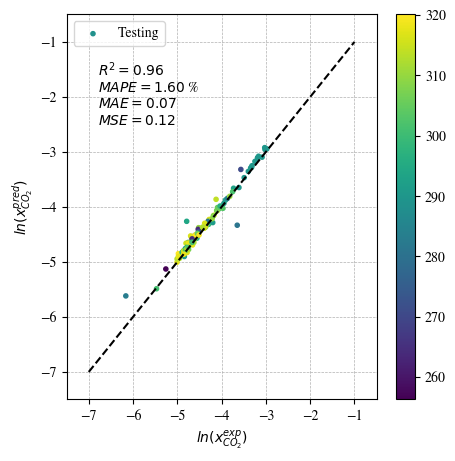

In [45]:
print('Original test points: ', test_df.shape[0])
test_df_exclusive = test_df
# filter out DES (including composition) that have not been seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]

# filter out points with temperatures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['T (K)'].isin(train_df['T (K)'].unique().tolist())]
# filter out points with  lower pressure than 250 kPa
print('Threshold value: ',max(test_df_exclusive['P (kPa)'])*.80)
test_df_exclusive = test_df_exclusive[test_df_exclusive['P (kPa)'] > max(test_df_exclusive['P (kPa)'])*0.80]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_P = test_df_exclusive['P (kPa)'].values
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_P)

Less errors were encounter when the pressure is closer to the pressure range of the training set. This can help us to define a limit to extrapolate with the pressure variable.

### Extrapolating to upper pressures

In [46]:
df = df_org.copy()

In [47]:
test_size = 0.30

threshold = 7620
mask_upper_P = df['P (kPa)'] > threshold
while mask_upper_P.sum()/mask_upper_P.shape[0] < test_size:
  threshold -= 1
  mask_upper_P = df['P (kPa)'] > threshold

print('Test proportion: ', mask_upper_P.sum()/mask_upper_P.shape[0])
print('Threshold P: ', threshold)

Test proportion:  0.3000506842372022
Threshold P:  738


In [48]:
df['Split'] = 'Training'
df.loc[mask_upper_P, 'Split'] = 'Testing'
df['Split'].value_counts()

Training    1381
Testing      592
Name: Split, dtype: int64

In [49]:
df[['Split', 'P (kPa)']]

,Split,P (kPa)
0,Training,63.7
1,Training,107.6
2,Training,192.5
3,Training,288.3
4,Training,382.9
...,...,...
1968,Training,112.5
1969,Training,421.4
1970,Testing,816.0
1971,Testing,1138.5


In [50]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

In [51]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

In [52]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [53]:
model_name = 'GNN_upper_P'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

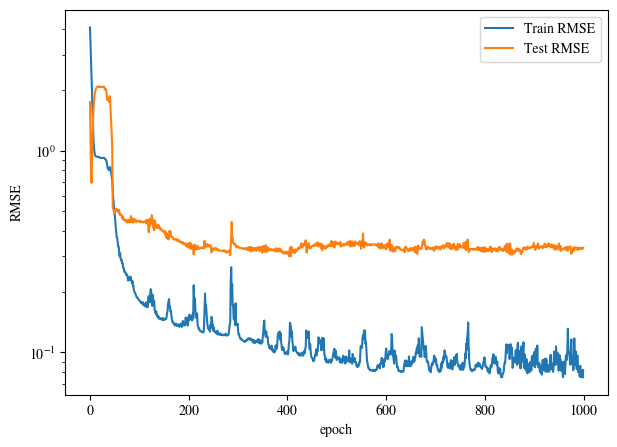

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [54]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

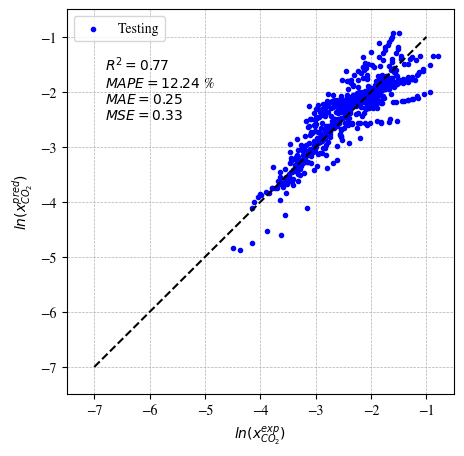

In [55]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [56]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have been not seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with temperatures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['T (K)'].isin(train_df['T (K)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_P =  test_df_exclusive['P (kPa)'].values #test_df_exclusive['P (kPa)'].values - threshold

Original test points:  592
Eliminated test points:  76
Remaining test points:  516


In [57]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

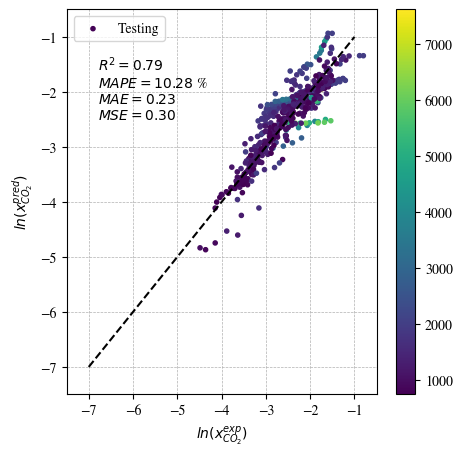

In [58]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_P)

Let's define a threshold of 900 kPA to determine how the model performs at closer values.

Original test points:  592
Threshold value: 886.8
Eliminated test points:  502
Remaining test points:  90


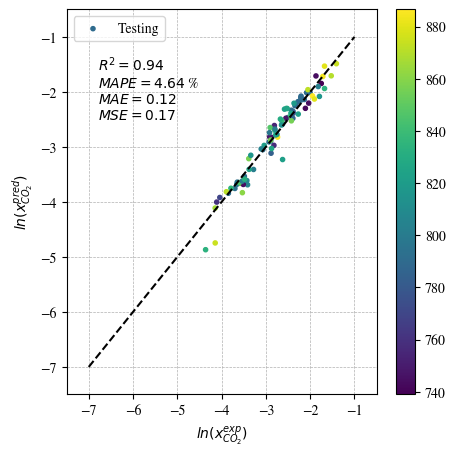

In [60]:
print('Original test points: ', test_df.shape[0])
test_df_exclusive = test_df
# filter out DES (including composition) that have not been seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]

# filter out points with temperatures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['T (K)'].isin(train_df['T (K)'].unique().tolist())]
# filter out points with  lower pressure than 250 kPa
print('Threshold value:', min(test_df_exclusive['P (kPa)'])*1.20)
test_df_exclusive = test_df_exclusive[test_df_exclusive['P (kPa)'] < min(test_df_exclusive['P (kPa)'])*1.20]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

y_test_excl = test_df_exclusive['ln(x)-experimental'].values
delta_P = test_df_exclusive['P (kPa)'].values
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_P)

Less error encounter at closer values. This can help to define an error when the model is used to extrpaolate at lower and upper values. Both thresholds values suggest that the model can extrapolate with a maximun 20 % from the training set.

### Interpolating among pressures

In [ ]:
df = df_org.copy()

In [ ]:
train_size = 0.70

threshold_1 = 26.3
threshold_2 = 7620
mask_inter_P = (df['P (kPa)'] < threshold_1) | (df['P (kPa)'] > threshold_2)
while mask_inter_P.sum()/mask_inter_P.shape[0] < train_size:
  threshold_1 += 1
  threshold_2 -= 1
  mask_inter_P = (df['P (kPa)'] < threshold_1) | (df['P (kPa)'] > threshold_2)

print('Train size: ', mask_inter_P.sum()/mask_inter_P.shape[0])
print('Threshold 1 T: ', threshold_1)
print('Threshold 2 T: ', threshold_2)

Train size:  0.7004561581348201
Threshold 1 T:  737.3
Threshold 2 T:  6909


In [ ]:
df['Split'] = 'Testing'
df.loc[mask_inter_P, 'Split'] = 'Training'
df['Split'].value_counts()

Training    1382
Testing      591
Name: Split, dtype: int64

In [ ]:
df[['Split', 'P (kPa)']]

,Split,P (kPa)
0,Training,63.7
1,Training,107.6
2,Training,192.5
3,Training,288.3
4,Training,382.9
...,...,...
1968,Training,112.5
1969,Training,421.4
1970,Testing,816.0
1971,Testing,1138.5


In [ ]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

In [ ]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

In [ ]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [ ]:
model_name = 'GNN_inter_P'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

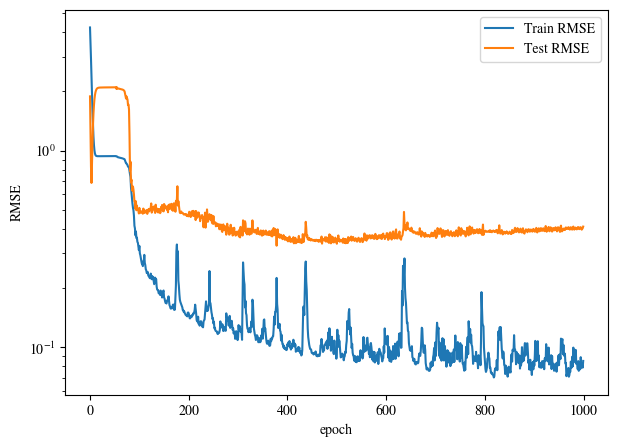

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

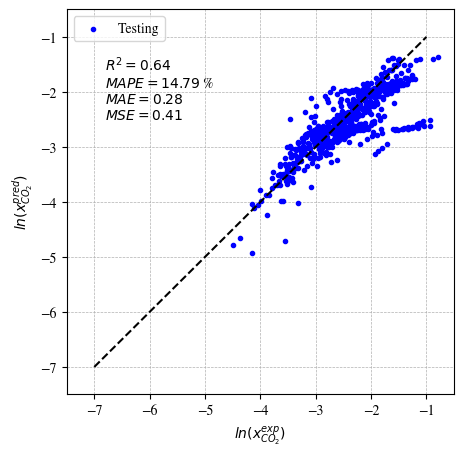

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [ ]:
print('Original test points: ', test_df.shape[0])

# filter out DES (including composition) that have been not seen during training
test_df_exclusive = test_df[test_df['DES standarized name'].isin(train_df['DES standarized name'].unique().tolist())]


# filter out points with temperatures that have not been seen during training
test_df_exclusive = test_df_exclusive[test_df_exclusive['T (K)'].isin(train_df['T (K)'].unique().tolist())]

print('Eliminated test points: ', test_df.shape[0] - test_df_exclusive.shape[0])
print('Remaining test points: ', test_df_exclusive.shape[0])

# create dataloader
test_excl_dataloader = get_dataloader_pairs(test_df_exclusive, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
delta_P =  test_df_exclusive['P (kPa)'].values
y_test_excl = test_df_exclusive['ln(x)-experimental'].values

Original test points:  591
Eliminated test points:  76
Remaining test points:  515


In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_excl_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

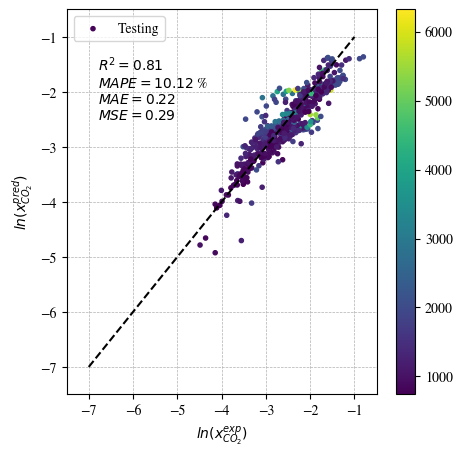

In [ ]:
parity_plots( y_train, y_hat_training, y_test_excl, y_hat_testing, color_vals=delta_P)